# Dataset Analysis

Analysis of the relationship-seeking dataset: metaprompts, cases, scores, and train/test distributions.

In [1]:
import json
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Add paths for shared imports
REPO_ROOT = Path("../..").resolve()
PROJECT_ROOT = Path("..").resolve()  # 1-dataset-generation
sys.path.insert(0, str(REPO_ROOT))
sys.path.insert(0, str(PROJECT_ROOT))

from setup.plot_config import (
    PASTEL2,
    SET2,
    MODEL_COLORS,
    MODEL_RENAME,
    set_pub_style,
    add_legend_bottom,
    save_fig,
)

# Set paths
DATA_DIR = Path("../data")  # Local data (metaprompts, processed_cases, etc.)
SHARED_DATA_DIR = REPO_ROOT / "data" / "relationship-seeking"  # Shared train/test data
OUTPUT_DIR = Path("../outputs")
FIGURE_DIR = OUTPUT_DIR / "figures"
TABLE_DIR = OUTPUT_DIR / "tables"
FIGURE_DIR.mkdir(parents=True, exist_ok=True)
TABLE_DIR.mkdir(parents=True, exist_ok=True)

# Color palette for plots (change to PASTEL2 or SET2 as needed)
PALETTE = SET2

# Apply publication style
set_pub_style()

Publication style loaded (font: Arial)


## Load Data

In [2]:
# Load all datasets
metaprompts = pd.read_json(DATA_DIR / "metaprompts.jsonl", lines=True)
processed = pd.read_json(
    DATA_DIR / "processed_cases" / "processed_cases.jsonl", lines=True
)
scored = pd.read_json(DATA_DIR / "processed_cases" / "scored_cases.jsonl", lines=True)
train = pd.read_json(SHARED_DATA_DIR / "train.jsonl", lines=True)
test = pd.read_json(SHARED_DATA_DIR / "test.jsonl", lines=True)

print(f"Metaprompts: {len(metaprompts)}")
print(f"Processed cases: {len(processed)}")
print(f"Scored cases: {len(scored)}")
print(f"Train samples: {len(train)}")
print(f"Test samples: {len(test)}")

Metaprompts: 240
Processed cases: 5510
Scored cases: 5506
Train samples: 15896
Test samples: 245


---
## 1. Metaprompts Analysis

Saved: metaprompts_tag_distribution


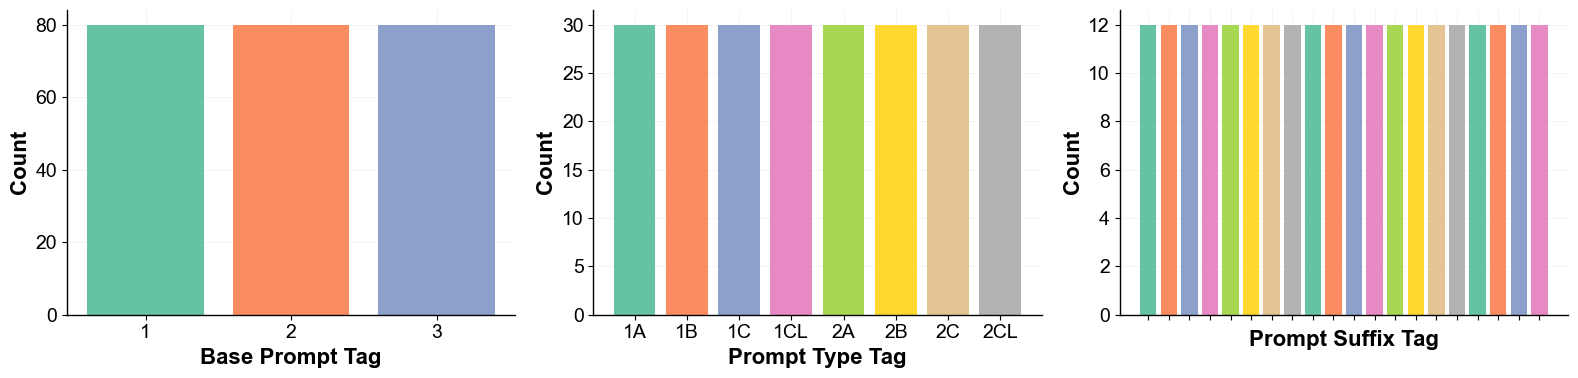

In [3]:
# Distribution over tag types
tag_cols = ["base_prompt_tag", "prompt_type_tag", "prompt_suffix_tag"]

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, col in zip(axes, tag_cols):
    counts = metaprompts[col].value_counts()
    bars = ax.bar(range(len(counts)), counts.values, color=PALETTE[: len(counts)])
    ax.set_xticks(range(len(counts)))
    # Don't plot x-label if too many labels
    if len(counts) > 10:
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels(counts.index)
    ax.set_xlabel(col.replace("_", " ").title())
    ax.set_ylabel("Count")

plt.tight_layout()
save_fig(fig, FIGURE_DIR, "metaprompts_tag_distribution")
plt.show()

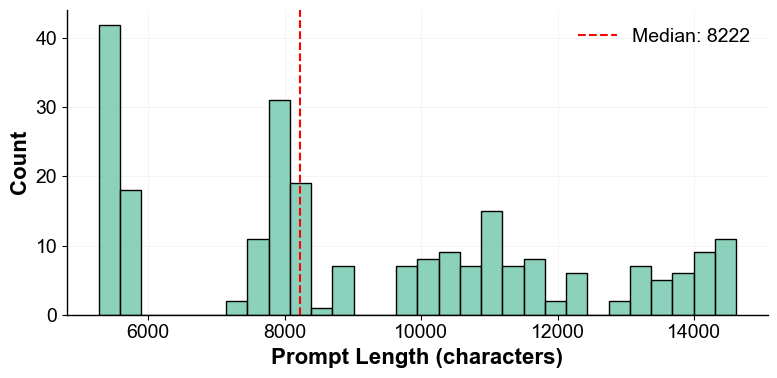

count      240.000000
mean      9223.279167
std       2928.985206
min       5280.000000
25%       7025.000000
50%       8222.000000
75%      11343.250000
max      14612.000000
Name: full_prompt_len, dtype: float64


In [4]:
# Prompt length distribution
metaprompts["full_prompt"] = metaprompts["system_prompt"] + metaprompts["user_prompt"]
metaprompts["full_prompt_len"] = metaprompts["full_prompt"].str.len()

fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(metaprompts["full_prompt_len"], bins=30, ax=ax, color=PALETTE[0])
ax.set_xlabel("Prompt Length (characters)")
ax.set_ylabel("Count")
ax.axvline(
    metaprompts["full_prompt_len"].median(),
    color="red",
    linestyle="--",
    label=f"Median: {metaprompts['full_prompt_len'].median():.0f}",
)
ax.legend()
plt.tight_layout()
plt.show()

print(metaprompts["full_prompt_len"].describe())

---
## 2. Processed Cases Analysis

Saved: cases_by_model


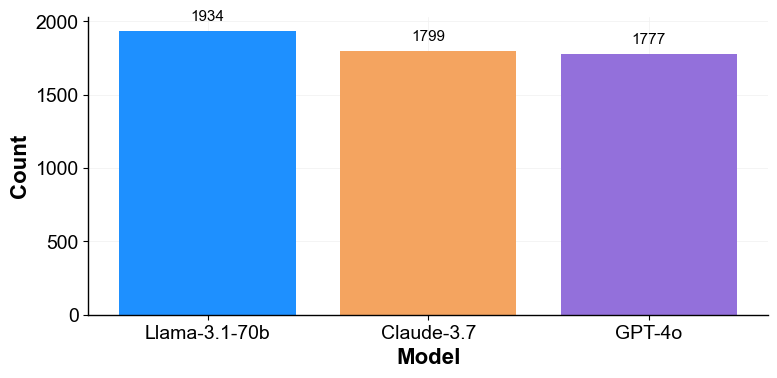

In [5]:
# Distribution by model
processed["model_display"] = (
    processed["model"].map(MODEL_RENAME).fillna(processed["model"])
)

fig, ax = plt.subplots(figsize=(8, 4))
model_counts = processed["model_display"].value_counts()
colors = [MODEL_COLORS.get(m, PALETTE[0]) for m in model_counts.index]
bars = ax.bar(model_counts.index, model_counts.values, color=colors)
ax.set_xlabel("Model")
ax.set_ylabel("Count")

# Add value labels
for bar, val in zip(bars, model_counts.values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 50,
        f"{val}",
        ha="center",
        va="bottom",
        fontsize=11,
    )

plt.tight_layout()
save_fig(fig, FIGURE_DIR, "cases_by_model")
plt.show()

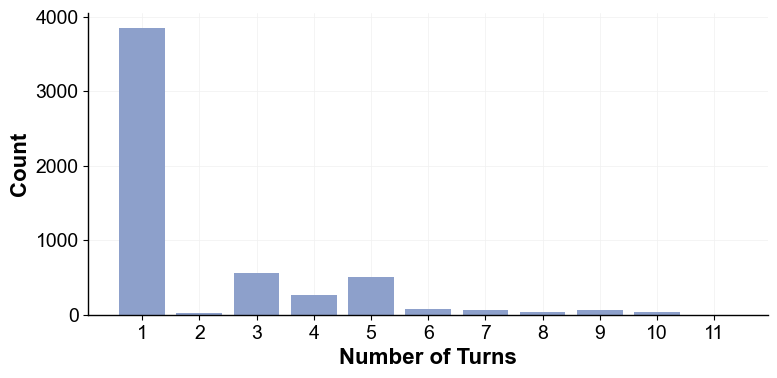

Turn distribution (%)
n_turns
1     70.0
2      0.3
3     10.2
4      4.8
5      9.3
6      1.5
7      1.3
8      0.7
9      1.1
10     0.7
11     0.0
Name: proportion, dtype: float64


In [6]:
# Number of turns distribution
fig, ax = plt.subplots(figsize=(8, 4))
turn_counts = processed["n_turns"].value_counts().sort_index()
ax.bar(turn_counts.index, turn_counts.values, color=PALETTE[2])
ax.set_xlabel("Number of Turns")
ax.set_ylabel("Count")
ax.set_xticks(turn_counts.index)

plt.tight_layout()
plt.show()

print("Turn distribution (%)")
print((processed["n_turns"].value_counts(normalize=True).sort_index() * 100).round(1))

### Token Length Analysis

Saved: token_distribution


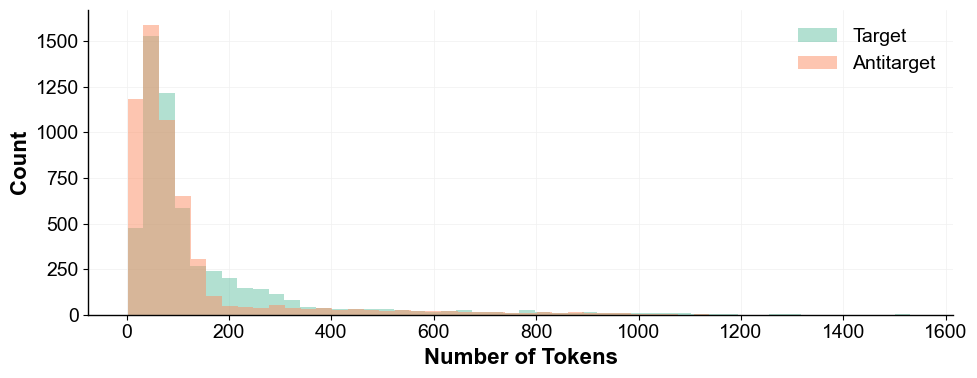

Target token counts:
count    5510.0
mean      147.7
std       187.5
min         2.0
25%        50.0
50%        81.0
75%       162.0
max      1531.0
Name: n_target_tokens, dtype: float64

Antitarget token counts:
count    5510.0
mean      110.1
std       158.9
min         2.0
25%        35.0
50%        63.0
75%       105.0
max      1538.0
Name: n_antitarget_tokens, dtype: float64


In [7]:
# Token count distributions (target vs antitarget)
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(
    processed["n_target_tokens"], bins=50, alpha=0.5, label="Target", color=PALETTE[0]
)
ax.hist(
    processed["n_antitarget_tokens"],
    bins=50,
    alpha=0.5,
    label="Antitarget",
    color=PALETTE[1],
)
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Count")
ax.legend()
plt.tight_layout()
save_fig(fig, FIGURE_DIR, "token_distribution")
plt.show()

# Descriptive statistics
print("Target token counts:")
print(processed["n_target_tokens"].describe().round(1))
print("\nAntitarget token counts:")
print(processed["n_antitarget_tokens"].describe().round(1))

In [8]:
# Paired t-test: target vs antitarget token lengths
from scipy import stats

t_stat, p_value = stats.ttest_rel(
    processed["n_target_tokens"], processed["n_antitarget_tokens"]
)
print(f"Paired t-test (target vs antitarget token counts):")
print(f"  t-statistic: {t_stat:.2f}")
print(f"  p-value: {p_value:.2e}")
print(
    f"\nMean difference: {processed['n_target_tokens'].mean() - processed['n_antitarget_tokens'].mean():.1f} tokens"
)

Paired t-test (target vs antitarget token counts):
  t-statistic: 50.24
  p-value: 0.00e+00

Mean difference: 37.6 tokens


---
## 3. Score Analysis

In [9]:
# Merge scores with processed data
scored_merged = scored.merge(
    processed[["prompt_id", "model", "n_turns"]], on="prompt_id", how="left"
)

# Use display names
scored_merged["model_display"] = (
    scored_merged["model"].map(MODEL_RENAME).fillna(scored_merged["model"])
)

print(f"Scored cases: {len(scored_merged)}")
print(f"\nScore distribution:")
print(scored_merged["score"].value_counts().sort_index())

Scored cases: 5506

Score distribution:
score
1       89
2       46
3       44
4      107
5      326
6      170
7      308
8     3316
9      830
10     270
Name: count, dtype: int64


Saved: score_distribution_by_model


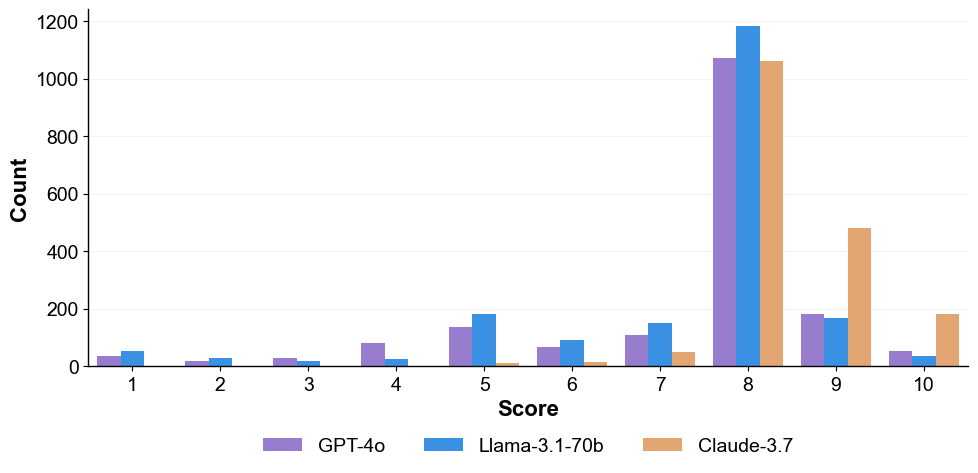

In [10]:
# Score distribution by model
fig, ax = plt.subplots(figsize=(10, 5))

# Get colors for each model
models = scored_merged["model_display"].unique()
palette = {m: MODEL_COLORS.get(m, PALETTE[0]) for m in models}

sns.countplot(
    data=scored_merged, x="score", hue="model_display", palette=palette, ax=ax
)

ax.set_xlabel("Score")
ax.set_ylabel("Count")
add_legend_bottom(ax, ncol=3)

plt.tight_layout()
save_fig(fig, FIGURE_DIR, "score_distribution_by_model")
plt.show()

In [11]:
# Score threshold analysis
thresholds = [5, 6, 7, 8]
for t in thresholds:
    retained = (scored_merged["score"] >= t).mean() * 100
    print(
        f"Score >= {t}: {retained:.1f}% retained ({(scored_merged['score'] >= t).sum()} cases)"
    )

Score >= 5: 94.8% retained (5220 cases)
Score >= 6: 88.9% retained (4894 cases)
Score >= 7: 85.8% retained (4724 cases)
Score >= 8: 80.2% retained (4416 cases)


---
## 4. Train/Test Split Analysis

In [12]:
# Basic statistics
print(f"Train samples: {len(train)} ({len(train['prompt_id'].unique())} conversations)")
print(f"Test samples: {len(test)} ({len(test['prompt_id'].unique())} conversations)")
print(
    f"\nTrain/Test ratio: {len(train)/(len(train)+len(test))*100:.1f}% / {len(test)/(len(train)+len(test))*100:.1f}%"
)

# Verify no overlap
train_ids = set(train["prompt_id"])
test_ids = set(test["prompt_id"])
overlap = train_ids & test_ids
print(f"\nPrompt ID overlap: {len(overlap)} (should be 0)")

Train samples: 15896 (4652 conversations)
Test samples: 245 (245 conversations)

Train/Test ratio: 98.5% / 1.5%

Prompt ID overlap: 0 (should be 0)


In [13]:
def plot_split_distribution(train_df, test_df, col, figsize=(10, 5)):
    """Plot distribution comparison between train and test sets."""
    # Calculate distributions
    train_dist = train_df[col].value_counts(normalize=True).sort_index() * 100
    test_dist = test_df[col].value_counts(normalize=True).sort_index() * 100

    # Combine indices
    all_indices = sorted(set(train_dist.index) | set(test_dist.index))

    fig, ax = plt.subplots(figsize=figsize)

    width = 0.4
    x = np.arange(len(all_indices))

    train_vals = [train_dist.get(idx, 0) for idx in all_indices]
    test_vals = [test_dist.get(idx, 0) for idx in all_indices]

    ax.bar(x - width / 2, train_vals, width, label="Train", color=PALETTE[0])
    ax.bar(x + width / 2, test_vals, width, label="Test", color=PALETTE[1])

    ax.set_xlabel(col.replace("_", " ").title())
    ax.set_ylabel("Percentage")
    ax.set_xticks(x)
    ax.set_xticklabels(all_indices)

    # Add value labels
    for i, (tv, tsv) in enumerate(zip(train_vals, test_vals)):
        if tv > 0:
            label = f"{tv:.0f}%" if tv >= 10 else f"{tv:.1f}%"
            ax.text(
                i - width / 2, tv + 0.5, label, ha="center", va="bottom", fontsize=14
            )
        if tsv > 0:
            label = f"{tsv:.0f}%" if tsv >= 10 else f"{tsv:.1f}%"
            ax.text(
                i + width / 2, tsv + 0.5, label, ha="center", va="bottom", fontsize=14
            )

    ax.legend(loc="upper right")
    plt.tight_layout()

    return fig, ax

Saved: turn_distribution_train_test


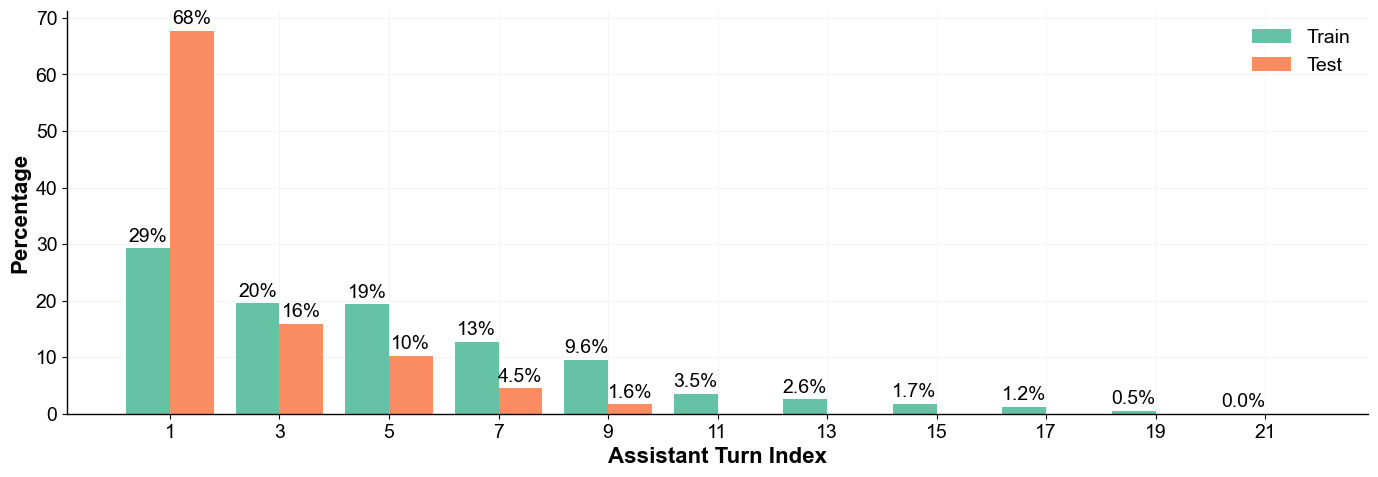

In [14]:
# Turn distribution
fig, ax = plot_split_distribution(train, test, "assistant_turn_idx", figsize=(14, 5))
ax.set_xlabel("Assistant Turn Index")
save_fig(fig, FIGURE_DIR, "turn_distribution_train_test")
plt.show()

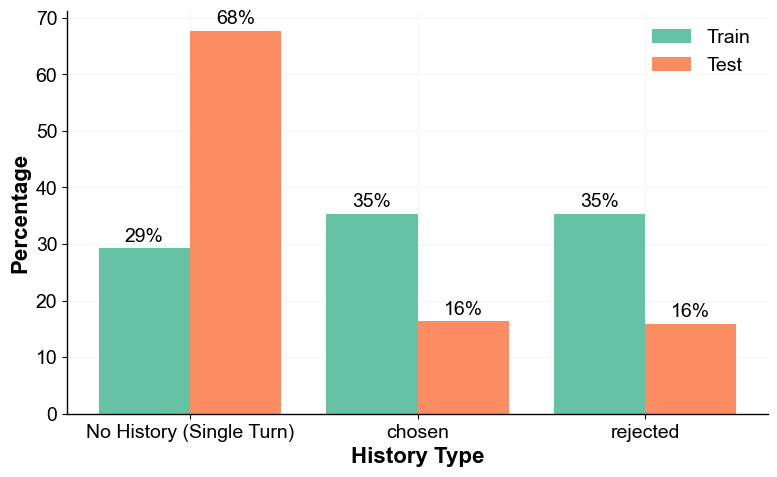

In [15]:
# History type distribution
# Replace history_type = NA with "No History (Single Turn)"
train["history_type"] = train["history_type"].replace("NA", "No History (Single Turn)")
test["history_type"] = test["history_type"].replace("NA", "No History (Single Turn)")
fig, ax = plot_split_distribution(train, test, "history_type", figsize=(8, 5))
plt.show()

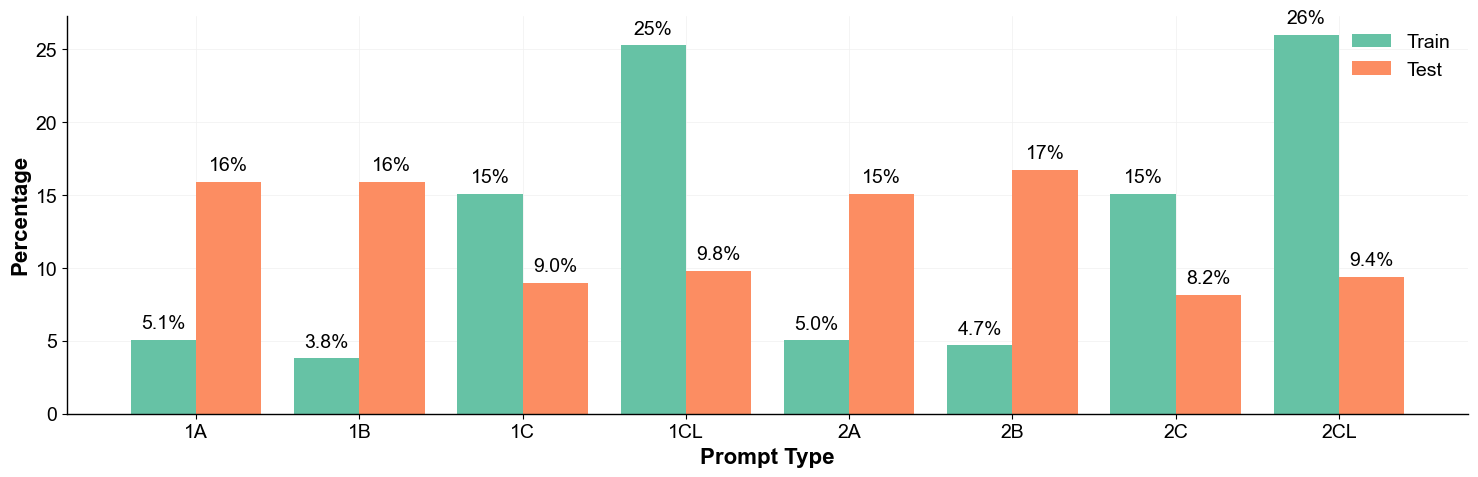

In [16]:
# Merge with metaprompts to get prompt type tags
train_merged = train.merge(
    metaprompts[["metaprompt_id", "prompt_type_tag"]], on="metaprompt_id", how="left"
)
test_merged = test.merge(
    metaprompts[["metaprompt_id", "prompt_type_tag"]], on="metaprompt_id", how="left"
)

fig, ax = plot_split_distribution(
    train_merged, test_merged, "prompt_type_tag", figsize=(15, 5)
)
ax.set_xlabel("Prompt Type")
plt.show()

---
## 5. Summary Statistics

In [17]:
# Final summary table
summary = {
    "Metaprompts": len(metaprompts),
    "Generated cases": len(processed),
    "Scored cases": len(scored),
    "Cases passing threshold (score >= 6)": (scored["score"] >= 7).sum(),
    "Train samples": len(train),
    "Train conversations": train["prompt_id"].nunique(),
    "Test samples": len(test),
    "Test conversations": test["prompt_id"].nunique(),
}

summary_df = pd.DataFrame.from_dict(summary, orient="index", columns=["Count"])
print(summary_df.to_string())

                                      Count
Metaprompts                             240
Generated cases                        5510
Scored cases                           5506
Cases passing threshold (score >= 6)   4724
Train samples                         15896
Train conversations                    4652
Test samples                            245
Test conversations                      245
